# Get Metloom Data
Created 4/9/2024
Author: Daniel Hogan

### Description
_________________
This notebook takes the basin geometries output from 04_valley_orientation.ipynb and grabs all the publicly available meteorological and snotel station data using `metloom`. Then, we manually downloaded the relavent data for stations with wind observations for each of their time series. We would have liked to use an API, but we are only granted access to data within the last year, so manual downloads were conducted. A plot of the location of each basin is then provided.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from metloom.pointdata import SnotelPointData, MesowestPointData
from metloom.variables import MesowestVariables, SnotelVariables
import matplotlib.pyplot as plt
import py3dep
from pynhd import NLDI
import datetime as dt
import glob
import os
import rioxarray as rxr

In [2]:
gdf = gpd.read_file('./01_data/processed_data/valley_orinetation_basins.geojson')

# Identify met stations to download from Synoptic.
I did this manually before I got authorization to get access to > 1 year of historic data. Accessed [here](https://download.synopticdata.com/#a/)
I used metloom to access the stations within each basin geometry, then I went ahead and downloaded the data for each location that had wind speed date. 

Then I did the same for snotel stations within each basin using the [report generator](https://wcc.sc.egov.usda.gov/reportGenerator/)
| ID | Name | State | Org |
| --- | --- | --- | --- |
| 380   | Butte  | CO |	SNTL |
| 386	| Cascade	| CO | SNTL |
| 387	| Cascade #2	| CO | SNTL |
| 465	| El Diente Peak	| CO | SNTL	|
| 531	| Hoosier Pass	| CO | SNTL	|
| 538	| Idarado	| CO | SNTL	|
| 586	| Lizard Head Pass	| CO | SNTL |
| 629	| Mineral Creek	| CO | SNTL	|
| 632	| Molas Lake	| CO | SNTL	|
| 680	| Park Cone	| CO | SNTL	|
| 713	| Red Mountain Pass	| CO | SNTL|
| 737	| Schofield Pass	| CO | SNTL	|
| 739	| Scotch Creek	| CO | SNTL	|
| 780	| Spud Mountain	| CO | SNTL	|
| 1141  | Upper Taylor	| CO | SNTL |


In [2]:
vrs_mw = [
    MesowestVariables.WINDSPEED,
    MesowestVariables.WINDDIRECTION,
    MesowestVariables.TEMP,
    MesowestVariables.PRECIPITATION,
    MesowestVariables.WETBULBTEMPERATURE,
    MesowestVariables.PRESSURE
]
vrs_sntl = [
    SnotelVariables.TEMP,
    SnotelVariables.PRECIPITATION,
    SnotelVariables.SNOWDEPTH,
    SnotelVariables.SWE
]


In [18]:
# lees ferry usgs gage
ucrb_boundary = gpd.read_file('./01_data/raw_data/geodata/Upper_Colorado_River_Basin_Boundary.json', driver='GeoJSON')


In [21]:
# get the 250 dem 
dem = py3dep.get_map("DEM", ucrb_boundary.iloc[0].geometry, resolution=250, crs="epsg:4326")


/tmp/ipykernel_11398/754359511.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
/tmp/ipykernel_11398/754359511.py:30: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  df_mw.plot(ax=ax, color='red', marker='*', label='Met Station (Mesowest)')
/tmp/ipykernel_11398/754359511.py:31: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  df_sntl.plot(ax=ax, color='blue', marker='*', label='SNTL')
/tmp/ipykernel_11398/754359511.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

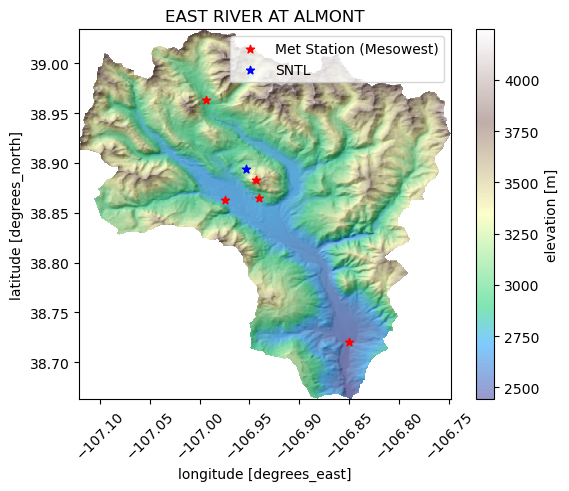

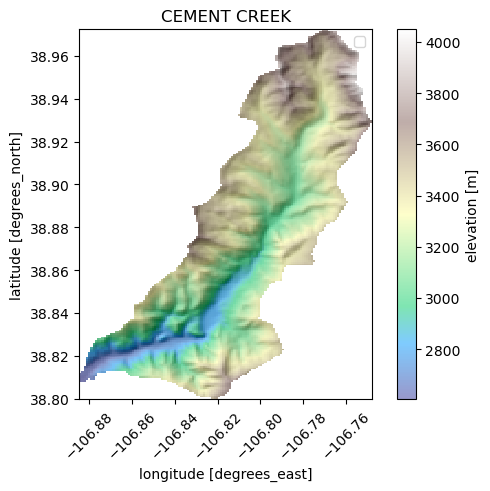

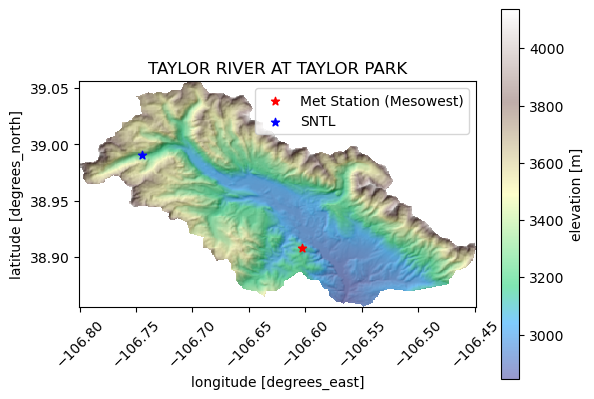

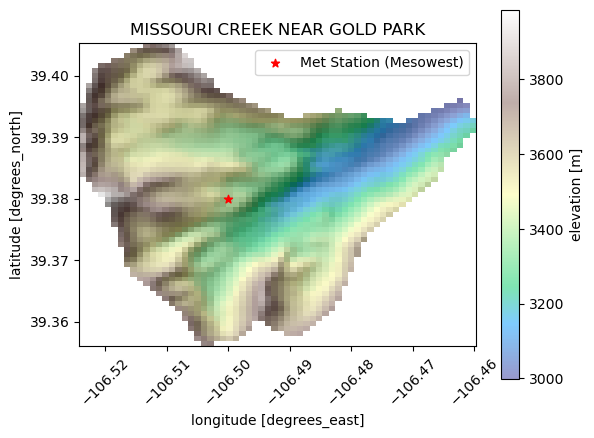

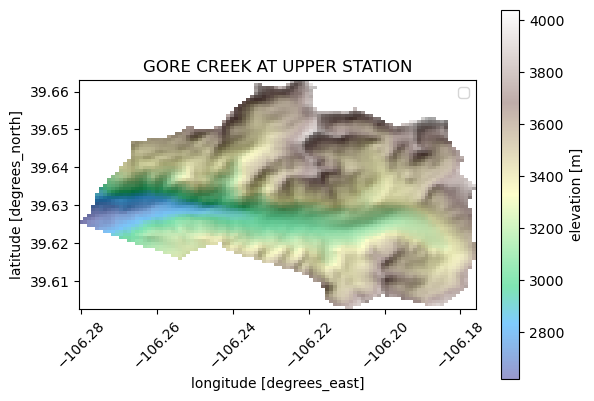

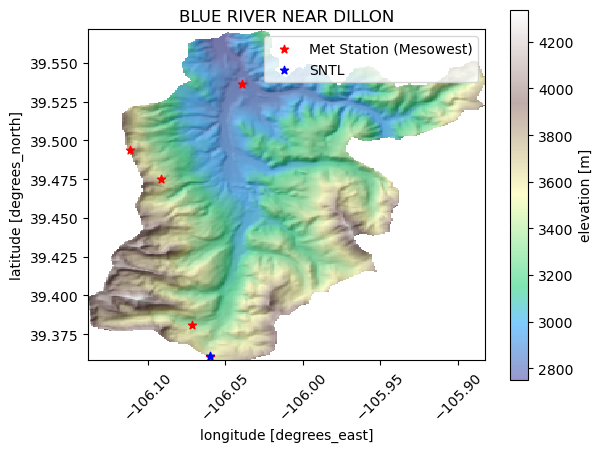

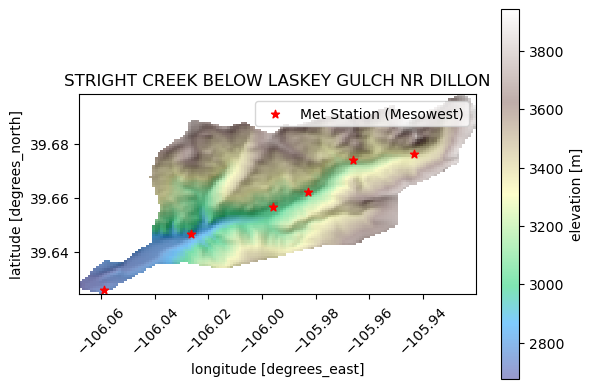

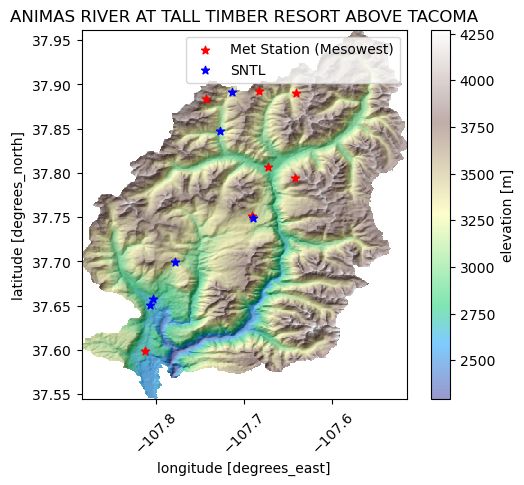

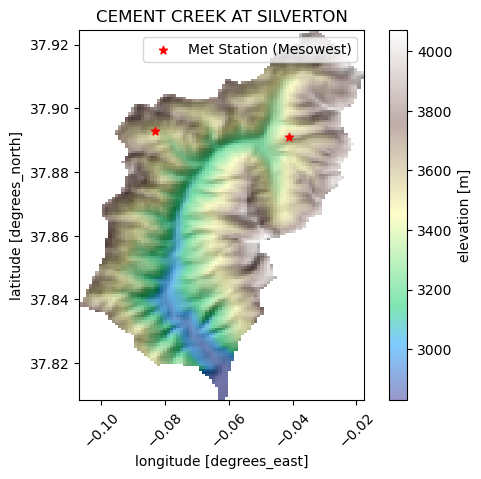

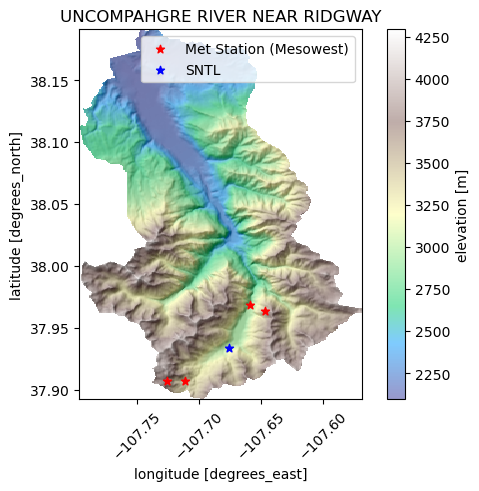

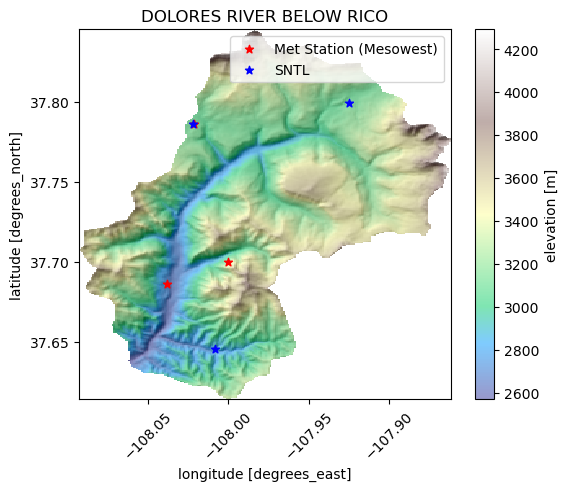

In [153]:
files = os.listdir('./01_data/raw_data/station_data/long_term_data/mesowest/')
# Loop through the files I downloaded and get a dataframe of all the stations associated with each basin. 
for i,name in enumerate(gdf["name"]):
    # Get SNOTEL and MESOWEST locations in the basin
    mesowest_points = MesowestPointData.points_from_geometry(gdf[gdf["name"] == name], vrs_mw)
    snotel_points = SnotelPointData.points_from_geometry(gdf[gdf["name"]==name], vrs_sntl)
    df_mw = mesowest_points.to_dataframe()
    df_sntl = snotel_points.to_dataframe()

    # split file on . and take the first part
    station_ids = [file.split('.')[0] for file in files]
    # filter to stations with data I want
    df_mw = df_mw[df_mw['id'].isin(station_ids)]

    # Plot up each basin and the locations of the valid stations
    # Get basin DEM and hillshade 
    geometry = gdf[gdf["name"]==name].geometry.values[0]
    dem = py3dep.get_dem(geometry, resolution=90, crs=4326)
    hillshade = py3dep.get_map("Hillshade Gray", geometry, resolution=90, geo_crs=4326, crs=4326)

    # plot it up
    fig, ax = plt.subplots()
    gdf[gdf["name"]==name].geometry.plot(ax=ax, color='white', edgecolor='black')
    hillshade.plot(ax=ax, cmap='gray', add_colorbar=False)
    dem.plot(ax=ax, cmap='terrain', alpha=0.5)

    df_mw.plot(ax=ax, color='red', marker='*', label='Met Station (Mesowest)')
    df_sntl.plot(ax=ax, color='blue', marker='*', label='SNTL')
    # rotate xlabels 45 degrees for visbility
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
    ax.legend()
    ax.set_title(name.replace("_", " ").upper())
    
    # concatenate the two dataframes
    if i == 0:
        df_final = pd.concat([df_mw, df_sntl])
        # adda column for the gdf name and index
        df_final["name"] = name
        df_final["gage_id"] = gdf[gdf["name"]==name].gage_id.values[0]
    else:
        df_tmp = pd.concat([df_mw, df_sntl])
        df_tmp["name"] = name
        df_tmp["gage_id"] = gdf[gdf["name"]==name].gage_id.values[0]
        df_final = pd.concat([df_final, df_tmp])

In [151]:
# reset the index
df_final = df_final.reset_index(drop=True)
# convert to geopandas
gdf_final = gpd.GeoDataFrame(df_final, geometry=df_final.geometry)
# save the geodataframe
gdf_final.to_file('./01_data/processed_data/met_station_metadata.geojson', driver='GeoJSON')

In [152]:
# THIS WONT WORK UNTIL I HAVE ACCESS TO HISTORICAL DATA THROUGHT THE API
# # Get the data for each of the points
# for id in df_mw["id"]:
#     mw_point = MesowestPointData(id, "mesowest")
#     df = mw_point.get_daily_data(
#         start_date=dt.datetime(2000,1,1),
#         end_date=dt.datetime(2020,1,1),
#         variables=vrs_mw
#     )
#     if df is None:
#         print(f"No data for {id}")
#         continue
#     else:
#         df.to_csv(f"./01_data/processed_data/{name}_mesowest_{id}.csv")
